In [338]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import infotopo
import networkx as nx
import seaborn as sns
import matplotlib.patches as patches
from sklearn.utils import Bunch
from itertools import combinations

Generate artificial networks with a preset redundancy and synergy. 

In [135]:
def generate_empty_simplicial_complex(num_nodes):
    """
    Generate a simplicial complex for a given number of nodes and weights zero.
    
    Parameters:
        num_nodes (int): The number of nodes.
        
    Returns:
        dict: A dictionary where keys are simplices (tuples) and values are zero.
    """
    if num_nodes <= 0:
        return {}

    # Initialize the dictionary to store simplices and their values
    simplicial_complex = {}
    nodes = range(1, num_nodes + 1)
    
    # Generate simplices and assign random values
    for r in range(1, num_nodes + 1):
        for simplex in combinations(nodes, r):
            simplicial_complex[simplex] = 0
    
    return simplicial_complex

In [146]:
def distribute_value(R_sum, S_sum, nb_of_variables):
    """
    Distribute a given value `R_sum` randomly into a list of length `nb_of_variables` 
    such that the sum of the list equals `R_sum`. Do the same for S_sum
    
    Parameters:
        R_sum (float): The sum of the positive MI values, representing redundant dependence.
        S_sum (float): The sum of the negative MI values, representing synergistic dependence.
        nb_of_variables (int): The amount of variables, i.e. nodes, of the system.
        
    Returns:
        list of float: A list of MI values, where sum(postive values)=R_sum and sum(negative values)=S_sum.
    """
    if nb_of_variables <= 0:
        return []

    nb_of_variables_R = random.randint(1, nb_of_variables - 1)
    nb_of_variables_S = nb_of_variables - nb_of_variables_R

    # Generate MI values for redundancy
    points_R = sorted([0] + [random.uniform(0, R_sum) for _ in range(nb_of_variables_R - 1)] + [R_sum])
    distributed_values_R = [points_R[i + 1] - points_R[i] for i in range(nb_of_variables_R)]

    # Generate MI values for synergy
    points_S = sorted([0] + [random.uniform(0, S_sum) for _ in range(nb_of_variables_S - 1)] + [S_sum])
    distributed_values_S = [-(points_S[i + 1] - points_S[i]) for i in range(nb_of_variables_S)]

    # Combine both lists
    distributed_values = distributed_values_R + distributed_values_S

    # Shuffle the combined list
    random.shuffle(distributed_values)

    return distributed_values

def assign_MI_values(simplicial_complex, R_sum, S_sum):
    """
    Assigns MI values to the components of the complex.
    For n=1: assign random MI values between 2 and 3
    For n=2: assign random MI values between 0 and 3
    For n>2: assign MI values from the resulting list of func "distribute_value"
    
    Parameters:
        R_sum (float): The sum of the positive MI values, representing redundant dependence.
        S_sum (float): The sum of the negative MI values, representing synergistic dependence.
        simplicial_complex (dict): Dictionary of the empty simplicial complex
        
    Returns:
        Simplicial complex (dict): resulting complex with assigned MI values
    """
    # Count the number of keys with length > 2
    count = sum(1 for key in simplicial_complex if len(key) > 2)

    # Get the distributed values for keys with length > 2
    distributed_values = distribute_value(R_sum, S_sum, count)

    # Iterator for distributing values to keys with length > 2
    distributed_values_iter = iter(distributed_values)

    # Iterate over the dictionary and assign values based on key length
    for key in simplicial_complex:
        key_length = len(key)
        
        if key_length == 1:
            # Assign random values between 2 and 3 for keylength 1
            simplicial_complex[key] = random.uniform(2, 3)
        elif key_length == 2:
            # Assign random values between 0 and 3 for keylength 2
            simplicial_complex[key] = random.uniform(0, 3)
        elif key_length > 2:
            # Assign randomly distributed redundancy and synergy values for keylength > 2
            simplicial_complex[key] = next(distributed_values_iter)
    
    return simplicial_complex

In [211]:
def compute_subset_tc_expectation(TC_dict, gamma):
    """
    Computes the expected total correlation for subsets of size gamma.
    
    Parameters:
        TC_dict (dict): Dictionary where keys are tuples (subsets) and values are total correlations.
        gamma (int): Size of the subset.
    
    Returns:
        float: Expected total correlation for subsets of size gamma.
    """
    subsets = [subset for subset in TC_dict if len(subset) == gamma]
    subset_tcs = [TC_dict[subset] for subset in subsets]
    return np.mean(subset_tcs) if subset_tcs else 0  # Return 0 if no subsets of size gamma exist

def compute_tse_complexity(TC_dict):
    """
    Computes the TSE complexity given a dictionary of total correlations.
    
    Parameters:
        TC_dict (dict): Dictionary of total correlations where keys are tuples (subsets).
        
    Returns:
        float: The TSE complexity.
    """
    N = max(len(subset) for subset in TC_dict)  # Maximum size of the subsets (full set)
    TSE = 0
    
    for gamma in range(1, N):
        TC_full = (gamma / N) * TC_dict[tuple(range(1, N + 1))]  # Full set correlation scaled by gamma/N
        E_TC_gamma = compute_subset_tc_expectation(TC_dict, gamma)
        TSE += TC_full - E_TC_gamma
    
    return TSE

In [258]:
def remove_extremes(data):
    """
    Removes the lowest 1% and highest 1% of values from the list.
    
    Parameters:
        data (list or numpy array): The input list of values.
    
    Returns:
        list: A list with the extreme values removed.
    """
    # Convert to a numpy array for easier percentile calculation
    data = np.array(data)
    
    # Calculate the 1st and 99th percentiles
    lower_bound = np.percentile(data, 1)
    upper_bound = np.percentile(data, 99)
    
    # Filter out values outside the range
    filtered_data = [x for x in data if lower_bound <= x <= upper_bound]
    
    return filtered_data

Set initial conditions and run functions accordingly

In [221]:
R_sum = 19
S_sum = 1
nb_of_variables = 10

empty_simplicial_complex = generate_empty_simplicial_complex(nb_of_variables)
Ninfomut_artificial = assign_MI_values(empty_simplicial_complex, R_sum, S_sum)
compute_tse_complexity(Ninfomut_artificial)

-4.224174448829338

Generate a large number of TSE values for extreme R and S distributions to observe behaviour

In [249]:
TSE_R = []
TSE_S = []
TSE_0 = []

for i in range(10000):
    R_sum = 100
    S_sum = 0
    nb_of_variables = 10

    empty_simplicial_complex = generate_empty_simplicial_complex(nb_of_variables)
    Ninfomut_artificial = assign_MI_values(empty_simplicial_complex, R_sum, S_sum)
    TSE_R.append(compute_tse_complexity(Ninfomut_artificial))

    R_sum = 0
    S_sum = 100
    nb_of_variables = 10

    empty_simplicial_complex = generate_empty_simplicial_complex(nb_of_variables)
    Ninfomut_artificial = assign_MI_values(empty_simplicial_complex, R_sum, S_sum)
    TSE_S.append(compute_tse_complexity(Ninfomut_artificial))

    R_sum = 50
    S_sum = 50
    nb_of_variables = 10

    empty_simplicial_complex = generate_empty_simplicial_complex(nb_of_variables)
    Ninfomut_artificial = assign_MI_values(empty_simplicial_complex, R_sum, S_sum)
    TSE_0.append(compute_tse_complexity(Ninfomut_artificial))

In [250]:
# Remove extreme values
TSE_R_filtered = remove_extremes(TSE_R)
TSE_S_filtered = remove_extremes(TSE_S)
TSE_0_filtered = remove_extremes(TSE_0)

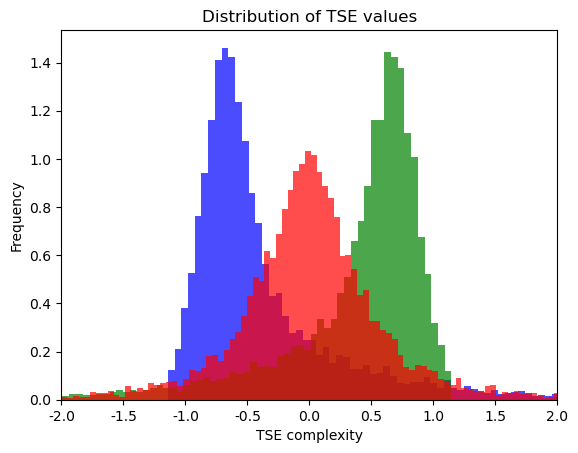

In [257]:
# Plot histograms for the three lists
plt.hist(TSE_R_filtered, bins=100, color='blue', alpha=0.7, label='R dominated networks', density=True)
plt.hist(TSE_S_filtered, bins=100, color='green', alpha=0.7, label='S dominated networks', density=True)
plt.hist(TSE_0_filtered, bins=100, color='red', alpha=0.7, label='Equal S and R', density=True)
plt.xlim(-6, -2)

# IF USEFUL FOR VISUALISATION # Rescale x-axis to make -4 correspond to 0
#ticks = plt.xticks()[0]  # Get current tick positions
#rescaled_ticks = ticks + 4  # Shift ticks by 4
#plt.xticks(ticks, [f"{t}" for t in rescaled_ticks])  # Update tick labels

# Add title and labels
plt.title('Distribution of TSE values')
plt.xlabel('TSE complexity')
plt.ylabel('Frequency')

# Add legend to distinguish the lists
#plt.legend()

# Show the plot
plt.show()

Now generate a range of R and S distributions to explore the TSE dependency on R and S.

In [369]:
# Assign values to each cell in the DataFrame
nb_of_variables = 10
simulations_per_S_R_balance = 1000
max_R_S_value = 1000
nb_of_R_S_values = 10

# Create an empty 10x10 DataFrame
stepsize = max_R_S_value/nb_of_R_S_values
max_MI_value = int(max_R_S_value + stepsize)
rows = [f"{i}" for i in np.arange(0, max_MI_value, int(stepsize))]  # Row labels
columns = [f"{j}" for j in np.arange(0, max_MI_value, int(stepsize))]  # Column labels
TSE_df = pd.DataFrame(index=rows, columns=columns)

for row in TSE_df.index:
    for col in TSE_df.columns:
        # Convert row and column to integers and print them
        R_sum = int(row)
        S_sum = int(col)
        TSE_sum = 0

        for i in range(simulations_per_S_R_balance):
            empty_simplicial_complex = generate_empty_simplicial_complex(nb_of_variables)
            Ninfomut_artificial = assign_MI_values(empty_simplicial_complex, R_sum, S_sum)
            TSE_value = compute_tse_complexity(Ninfomut_artificial)
            TSE_sum += TSE_value
        
        TSE_average = TSE_sum / simulations_per_S_R_balance

        # Assign the incremental value to the DataFrame cell
        TSE_df.loc[row, col] = TSE_average

KeyboardInterrupt: 

Rewrite the code to improve speed

In [376]:
import numpy as np
import pandas as pd
import random
from joblib import Parallel, delayed
import itertools

# Optimized function to generate an empty simplicial complex
def generate_empty_simplicial_complex(num_nodes):
    """Generate an empty simplicial complex."""
    nodes = np.arange(1, num_nodes + 1)
    simplicial_complex = {}
    for r in range(1, num_nodes + 1):
        simplices = itertools.combinations(nodes, r)
        for simplex in simplices:
            simplicial_complex[simplex] = 0
    return simplicial_complex

# Optimized function to distribute values for R and S sums
def distribute_value(R_sum, S_sum, nb_of_variables):
    """Distribute values efficiently using NumPy."""
    nb_of_variables_R = random.randint(1, nb_of_variables - 1)
    nb_of_variables_S = nb_of_variables - nb_of_variables_R

    # Generate R and S distributions using numpy for efficiency
    points_R = np.sort(np.random.uniform(0, R_sum, nb_of_variables_R - 1))
    points_R = np.concatenate(([0], points_R, [R_sum]))
    distributed_values_R = np.diff(points_R)

    points_S = np.sort(np.random.uniform(0, S_sum, nb_of_variables_S - 1))
    points_S = np.concatenate(([0], points_S, [S_sum]))
    distributed_values_S = np.diff(points_S)

    # Combine, shuffle, and return the values
    distributed_values = np.concatenate([distributed_values_R, -distributed_values_S])
    np.random.shuffle(distributed_values)

    return distributed_values

# Optimized function to assign MI values
def assign_MI_values(simplicial_complex, R_sum, S_sum):
    """Assign MI values to simplicial complex efficiently."""
    count = sum(1 for key in simplicial_complex if len(key) > 2)
    distributed_values = distribute_value(R_sum, S_sum, count)
    distributed_values_iter = iter(distributed_values)

    for key in simplicial_complex:
        key_length = len(key)
        if key_length == 1:
            simplicial_complex[key] = random.uniform(2, 3)
        elif key_length == 2:
            simplicial_complex[key] = random.uniform(0, 3)
        elif key_length > 2:
            simplicial_complex[key] = next(distributed_values_iter)
    
    return simplicial_complex

# Optimized function to compute TSE complexity
def compute_tse_complexity(TC_dict):
    """Compute TSE complexity efficiently."""
    N = max(len(subset) for subset in TC_dict)  # Maximum subset size
    TSE = 0
    for gamma in range(1, N):
        TC_full = (gamma / N) * TC_dict[tuple(range(1, N + 1))]
        E_TC_gamma = np.mean([TC_dict[subset] for subset in TC_dict if len(subset) == gamma])
        TSE += TC_full - E_TC_gamma
    return TSE

# Function to perform simulation for a given R and S
def simulate_TSE(R_sum, S_sum, nb_of_variables, simulations_per_S_R_balance):
    """Simulate TSE calculation for a given R_sum and S_sum."""
    TSE_sum = 0
    for _ in range(simulations_per_S_R_balance):
        empty_simplicial_complex = generate_empty_simplicial_complex(nb_of_variables)
        Ninfomut_artificial = assign_MI_values(empty_simplicial_complex, R_sum, S_sum)
        TSE_value = compute_tse_complexity(Ninfomut_artificial)
        TSE_sum += TSE_value
    TSE_average = TSE_sum / simulations_per_S_R_balance
    return TSE_average

# Parallel processing for the DataFrame assignment
def fill_TSE_df(TSE_df, nb_of_variables, simulations_per_S_R_balance):
    """Fill the TSE DataFrame using parallel processing."""
    rows, cols = TSE_df.index, TSE_df.columns
    results = Parallel(n_jobs=-1)(delayed(simulate_TSE)(int(row), int(col), nb_of_variables, simulations_per_S_R_balance)
                                  for row in rows for col in cols)
    
    result_idx = 0
    for row in rows:
        for col in cols:
            TSE_df.loc[row, col] = results[result_idx]
            result_idx += 1
    return TSE_df

In [389]:
# Main script
nb_of_variables = 10
simulations_per_S_R_balance = 10000
max_R_S_value = 10000
nb_of_R_S_values = 20

# Create empty DataFrame with appropriate row/column labels
stepsize = max_R_S_value / nb_of_R_S_values
max_MI_value = int(max_R_S_value + stepsize)
rows = [f"{i}" for i in np.arange(0, max_MI_value, int(stepsize))]
columns = [f"{j}" for j in np.arange(0, max_MI_value, int(stepsize))]
TSE_df = pd.DataFrame(index=rows, columns=columns)

# Fill the DataFrame in parallel
TSE_df = fill_TSE_df(TSE_df, nb_of_variables, simulations_per_S_R_balance)

Plot the TSE values in a heatmap to visualise the dependence on redundancy and synergy

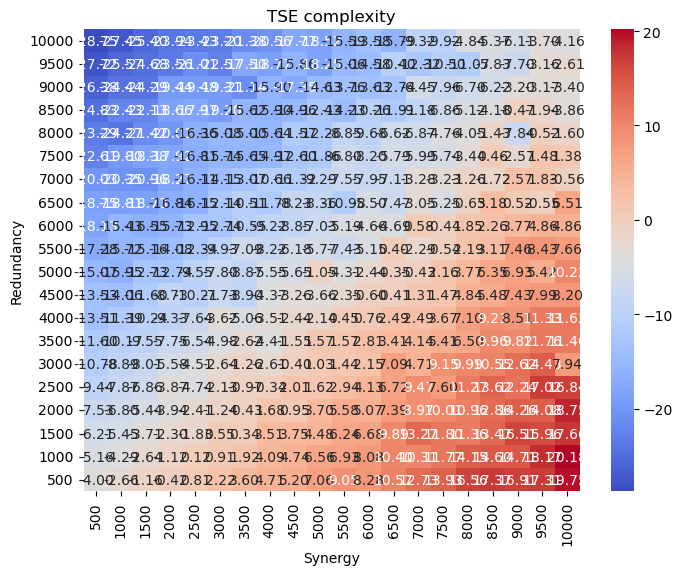

In [390]:
# Ensure the data is numeric
TSE_df = TSE_df.apply(pd.to_numeric, errors='coerce')

# Exclude the first row and column
heatmap_data = TSE_df.iloc[1:, 1:]

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)

# Invert the y-axis
plt.gca().invert_yaxis()

# Add title and labels
plt.title("TSE complexity")
plt.xlabel("Synergy")
plt.ylabel("Redundancy")

# Show the plot
plt.show()

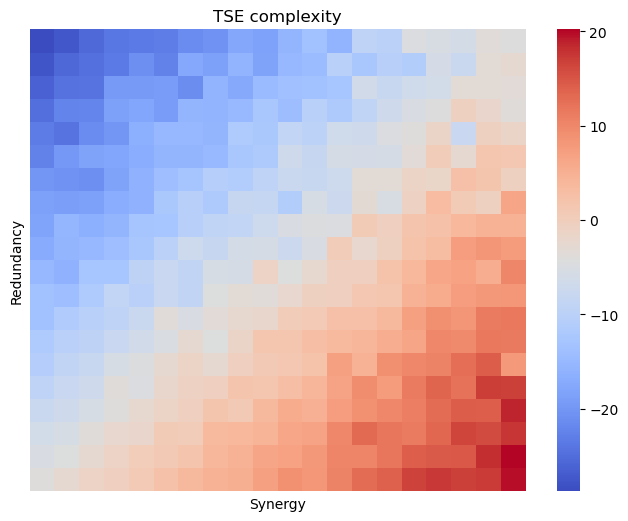

In [391]:
# Ensure the data is numeric
TSE_df = TSE_df.apply(pd.to_numeric, errors='coerce')

# Exclude the first row and column
heatmap_data = TSE_df.iloc[1:, 1:]

# Plot the heatmap without annotations
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=False, cmap="coolwarm", cbar=True)

# Invert the y-axis
plt.gca().invert_yaxis()

# Hide the axis ticks but keep the labels
plt.xticks([])  # Hide x-axis ticks
plt.yticks([])  # Hide y-axis ticks

# Add title with axis labels
plt.title("TSE complexity")
plt.xlabel("Synergy")
plt.ylabel("Redundancy")

# Show the plot
plt.show()